# This code represents a trading strategy for 1 hour trading intervals
# The predictor is the high price of the Avalanche (AVAX) cryptocurrency and the minimum threshold is 0.5

In [1]:
################# IMPORTS AND SETUP ##############################


from binance import Client
import pandas as pd
from supporting_functionsM2 import *
from API_KEYS2 import get_keys

# Setting up binance client
KEY, SECRET = get_keys()
client = Client(KEY, SECRET)

# Defining setup variables for creating dataset
# start = "1513724400" # 20.12.2017
start = "1483225200" # 01.01.2017
periods = 125 # approx 8 years
TICKER = "AVAXUSDT"
options = ["high", "low", "close", "volume"] # BASE OPTIONS
EPOCHS=5
THRESHOLD=0.5 # Threshold value for lableling, ie. BTCUSDT:close = 0.5 > 0.0 => label = 1, if BTCUSDT:close = -0.5 < 0.0 => 0
PREDICTOR=f"{TICKER}:high"
TIME = f"{TICKER}:time"

In [2]:
################# DOWNLOADING RAW DATA ##########################################

periods = periods
LIMIT = 720 # 720h = 30 days
start1 = start
end1 = next_30_days_unix_timestamp(start1)

############################################ DOWNLOADING DATA ###################################################################### 
data = pd.DataFrame(columns=["time", "open", "high", "low", "close", "volume"])

# downloading the first set of candlestick lines
klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

# Converting data from list to pandas dataframe
new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])
data = pd.concat([data, new_data], ignore_index=True)

for i in range(periods - 1):
    # Moving the start and end interval to next day
    start1 = next_30_days_unix_timestamp(start1)
    end1 = next_30_days_unix_timestamp(start1) 

    # downloading candlestick lines
    klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

    # Converting data from list to pandas dataframe
    new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])

    # concatinating the new data with the existing data
    data = pd.concat([data, new_data], ignore_index=True)

# converting all time values from unix to readable string, not important, just for visual purposes and fact checking
data["time"] = data["time"].apply(unix_to_datetime_string) #converting time from 

raw_data = data
display(raw_data)


,time,open,high,low,close,volume
0,2020-09-22 06:00:00,0.85000000,6.00000000,0.85000000,4.88110000,3198372.67000000
1,2020-09-22 07:00:00,4.88000000,5.35000000,4.24500000,4.90960000,3171013.60000000
2,2020-09-22 08:00:00,4.90960000,6.92890000,4.82000000,6.82190000,3883981.43000000
3,2020-09-22 09:00:00,6.82990000,7.00000000,5.55000000,6.21080000,3681832.89000000
4,2020-09-22 10:00:00,6.21090000,6.30000000,4.97500000,5.49010000,2729116.18000000
...,...,...,...,...,...,...
39135,2025-03-11 09:00:00,17.15000000,17.35000000,17.14000000,17.15000000,147311.80000000
39136,2025-03-11 10:00:00,17.15000000,17.32000000,17.11000000,17.25000000,115523.27000000
39137,2025-03-11 11:00:00,17.25000000,17.46000000,17.10000000,17.36000000,118959.05000000
39138,2025-03-11 12:00:00,17.36000000,17.39000000,16.98000000,17.05000000,243755.14000000


In [3]:
########################################## PREPROCESSING DATA ####################################################################

# New dataobject for storing processed data
# processed_data = {f"{TICKER}:time": [], f"{TICKER}:open": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}
processed_data = {f"{TICKER}:time": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}

for i, o in enumerate(raw_data["open"]): #o == open, the open price value of the candle stick
    if i == 0: #Skipping the first hour to calculate the percent diff using this hour
        continue

    if o == 0:
        continue

    processed_data[f"{TICKER}:time"].append(raw_data["time"][i]) #time is the same
    # processed_data[f"{TICKER}:open"].append(percent_difference(float(data["open"][i-1]), float(o))) # percent difference between the opening price of the prior candlestick vs. open of current candle
    processed_data[f"{TICKER}:high"].append(percent_difference(float(o), float(raw_data["high"][i]))) # percent diff between open and high
    processed_data[f"{TICKER}:low"].append(percent_difference(float(o), float(raw_data["low"][i]))) # percent diff between open and low
    processed_data[f"{TICKER}:close"].append(percent_difference(float(o), float(raw_data["close"][i]))) # percent diff between open and close
    processed_data[f"{TICKER}:volume"].append(percent_difference(float(raw_data["volume"][i-1]), float(raw_data["volume"][i]))) # percent difference between the colume of the prior candlestick vs. open of current candle


# processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:open", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
display(processed_data)

,AVAXUSDT:time,AVAXUSDT:high,AVAXUSDT:low,AVAXUSDT:close,AVAXUSDT:volume
0,2020-09-22 07:00:00,9.631148,-13.012295,0.606557,-0.855406
1,2020-09-22 08:00:00,41.129624,-1.824996,38.950220,22.483910
2,2020-09-22 09:00:00,2.490520,-18.739659,-9.064554,-5.204673
3,2020-09-22 10:00:00,1.434575,-19.898887,-11.605403,-25.876153
4,2020-09-22 11:00:00,12.410210,-4.628988,5.157703,-29.960694
...,...,...,...,...,...
39134,2025-03-11 09:00:00,1.166181,-0.058309,0.000000,-35.157967
39135,2025-03-11 10:00:00,0.991254,-0.233236,0.583090,-21.579079
39136,2025-03-11 11:00:00,1.217391,-0.869565,0.637681,2.974102
39137,2025-03-11 12:00:00,0.172811,-2.188940,-1.785714,104.906764


In [4]:
############################# STATISTICAL ANALYSIS OF PROCESSED DATA #######################################
high_data_processed = processed_data[f"{TICKER}:high"].to_list()

print(f"MAX HIGH IN DATASET: {max(high_data_processed)}")
print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 0.5 for x in high_data_processed) / len(high_data_processed)}")
print(f"OCCURRENCES OVER 0.6: {sum(x > 0.6 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 0.6 for x in high_data_processed) / len(high_data_processed)}")
print(f"OCCURRENCES OVER 0.7: {sum(x > 0.7 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 0.7 for x in high_data_processed) / len(high_data_processed)}")
print(f"OCCURRENCES OVER 0.8: {sum(x > 0.8 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 0.8 for x in high_data_processed) / len(high_data_processed)}")
print(f"OCCURRENCES OVER 0.9: {sum(x > 0.9 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 0.9 for x in high_data_processed) / len(high_data_processed)}")
print(f"OCCURRENCES OVER 1: {sum(x > 1 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 1 for x in high_data_processed) / len(high_data_processed)}")
print("----------------------------------------------------------------------")

close_data_processed = processed_data[f"{TICKER}:close"].to_list()

print(f"MAX CLOSE IN DATASET: {max(close_data_processed)}")
print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.5 for x in close_data_processed) / len(close_data_processed)}")
print(f"OCCURRENCES OVER 0.6: {sum(x > 0.6 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.6 for x in close_data_processed) / len(close_data_processed)}")
print(f"OCCURRENCES OVER 0.7: {sum(x > 0.7 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.7 for x in close_data_processed) / len(close_data_processed)}")
print(f"OCCURRENCES OVER 0.8: {sum(x > 0.8 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.8 for x in close_data_processed) / len(close_data_processed)}")
print(f"OCCURRENCES OVER 0.9: {sum(x > 0.9 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.9 for x in close_data_processed) / len(close_data_processed)}")
print(f"OCCURRENCES OVER 1: {sum(x > 1 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 1 for x in close_data_processed) / len(close_data_processed)}")

MAX HIGH IN DATASET: 41.12962359459018
OCCURRENCES OVER 0.5: 21165 - PERCENT OF DATASET: 0.5407649658907995
OCCURRENCES OVER 0.6: 18720 - PERCENT OF DATASET: 0.4782953064718056
OCCURRENCES OVER 0.7: 16447 - PERCENT OF DATASET: 0.420220240680651
OCCURRENCES OVER 0.8: 14561 - PERCENT OF DATASET: 0.3720330105521347
OCCURRENCES OVER 0.9: 12908 - PERCENT OF DATASET: 0.3297989217915634
OCCURRENCES OVER 1: 11476 - PERCENT OF DATASET: 0.29321137484350646
----------------------------------------------------------------------
MAX CLOSE IN DATASET: 38.95021997718755
OCCURRENCES OVER 0.5: 10645 - PERCENT OF DATASET: 0.27197935562993436
OCCURRENCES OVER 0.6: 9403 - PERCENT OF DATASET: 0.24024630164286262
OCCURRENCES OVER 0.7: 8242 - PERCENT OF DATASET: 0.21058279465494775
OCCURRENCES OVER 0.8: 7282 - PERCENT OF DATASET: 0.18605483022049618
OCCURRENCES OVER 0.9: 6440 - PERCENT OF DATASET: 0.16454176141444596
OCCURRENCES OVER 1: 5679 - PERCENT OF DATASET: 0.14509823960755258


In [5]:
########################### LABELING THE DATA ##################################


# column_labels = ["BTCUSDT:time"] # name of the columns for the return dataframe
column_labels = ["time"] # name of the columns for the return dataframe

# filling up the list with labels for the columns
for roundd in range(EPOCHS):
    for option in options:
        column_labels.append(f"{TICKER}:{option}{roundd}")

column_labels.append("Label")


# filling up list of data, row by row in the dataset
labelled_data_rows = [] # this list stores all the rows filled with all the data
for i in range(len(processed_data[TIME]) - EPOCHS): #looping from the third element to the third last element, with stepsize 1, if epoch=3
    data_row = []

    data_row.append(processed_data[TIME][i + EPOCHS - 1])

    for t in range(EPOCHS):
        for option in options:
            data_row.append(processed_data[f"{TICKER}:{option}"][i + t])

    if processed_data[PREDICTOR][i + EPOCHS] > THRESHOLD: # here we use the threshold
        data_row.append(1)
    else:
        data_row.append(0)

    labelled_data_rows.append(data_row)


labelled_data_frame = pd.DataFrame(labelled_data_rows, columns=column_labels)
display(labelled_data_frame)

,time,AVAXUSDT:high0,AVAXUSDT:low0,AVAXUSDT:close0,AVAXUSDT:volume0,AVAXUSDT:high1,AVAXUSDT:low1,AVAXUSDT:close1,AVAXUSDT:volume1,AVAXUSDT:high2,...,AVAXUSDT:volume2,AVAXUSDT:high3,AVAXUSDT:low3,AVAXUSDT:close3,AVAXUSDT:volume3,AVAXUSDT:high4,AVAXUSDT:low4,AVAXUSDT:close4,AVAXUSDT:volume4,Label
0,2020-09-22 11:00:00,9.631148,-13.012295,0.606557,-0.855406,41.129624,-1.824996,38.950220,22.483910,2.490520,...,-5.204673,1.434575,-19.898887,-11.605403,-25.876153,12.410210,-4.628988,5.157703,-29.960694,1
1,2020-09-22 12:00:00,41.129624,-1.824996,38.950220,22.483910,2.490520,-18.739659,-9.064554,-5.204673,1.434575,...,-25.876153,12.410210,-4.628988,5.157703,-29.960694,6.624595,-5.636367,1.536088,-26.807353,1
2,2020-09-22 13:00:00,2.490520,-18.739659,-9.064554,-5.204673,1.434575,-19.898887,-11.605403,-25.876153,12.410210,...,-29.960694,6.624595,-5.636367,1.536088,-26.807353,2.108768,-8.882438,-5.896013,-21.374516,1
3,2020-09-22 14:00:00,1.434575,-19.898887,-11.605403,-25.876153,12.410210,-4.628988,5.157703,-29.960694,6.624595,...,-26.807353,2.108768,-8.882438,-5.896013,-21.374516,1.625425,-8.365302,-6.238068,8.670055,0
4,2020-09-22 15:00:00,12.410210,-4.628988,5.157703,-29.960694,6.624595,-5.636367,1.536088,-26.807353,2.108768,...,-21.374516,1.625425,-8.365302,-6.238068,8.670055,0.089282,-16.327006,-9.361050,93.927123,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39129,2025-03-11 08:00:00,2.230259,-0.361664,0.421941,-46.110424,2.521008,-0.180072,1.500600,-34.977995,0.827912,...,-24.730260,1.846337,-0.059559,1.072067,-4.995078,2.004717,-0.471698,1.120283,56.320562,1
39130,2025-03-11 09:00:00,2.521008,-0.180072,1.500600,-34.977995,0.827912,-0.827912,-0.709639,-24.730260,1.846337,...,-4.995078,2.004717,-0.471698,1.120283,56.320562,1.166181,-0.058309,0.000000,-35.157967,1
39131,2025-03-11 10:00:00,0.827912,-0.827912,-0.709639,-24.730260,1.846337,-0.059559,1.072067,-4.995078,2.004717,...,56.320562,1.166181,-0.058309,0.000000,-35.157967,0.991254,-0.233236,0.583090,-21.579079,1
39132,2025-03-11 11:00:00,1.846337,-0.059559,1.072067,-4.995078,2.004717,-0.471698,1.120283,56.320562,1.166181,...,-35.157967,0.991254,-0.233236,0.583090,-21.579079,1.217391,-0.869565,0.637681,2.974102,0


# Model Training

This code block divides the dataset into a training dataset and trains a new model using the **AutoGluon Tabular** predictor.

In [6]:
################################ TRAINING NEW MODEL #######################################
from autogluon.tabular import TabularDataset, TabularPredictor

# defining training size and colums to use for training within the labelled dataset
VALIDATION_SIZE = 10000
columns_to_use = [f"{TICKER}:high0", f"{TICKER}:low0", f"{TICKER}:close0", f"{TICKER}:volume0", f"{TICKER}:high1", f"{TICKER}:low1", f"{TICKER}:close1", f"{TICKER}:volume1", f"{TICKER}:high2", f"{TICKER}:low2", f"{TICKER}:close2", f"{TICKER}:volume2", f"{TICKER}:high3", f"{TICKER}:low3", f"{TICKER}:close3", f"{TICKER}:volume3", f"{TICKER}:high4", f"{TICKER}:low4", f"{TICKER}:close4", f"{TICKER}:volume4", "Label"]
LABEL = "Label"

# defining training data
training_dataframe = labelled_data_frame.iloc[:-VALIDATION_SIZE].copy()
train_data_frame2 = training_dataframe[columns_to_use]
train_tabular_dataset = TabularDataset(train_data_frame2)

# # Training model -> TabularPredictor
# predictor = TabularPredictor(label=label, eval_metric="balanced_accuracy", positive_class=1).fit(train_tabular_dataset, num_bag_folds=5, num_bag_sets=5, num_stack_levels=3)
# predictor = TabularPredictor(label=label, eval_metric="accuracy").fit(train_tabular_dataset, presets="high_quality")
predictor = TabularPredictor(label=LABEL).fit(train_tabular_dataset)



c:\Users\47981\Desktop\MasterThesis\Repo\MasterThesis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No path specified. Models will be saved in: "AutogluonModels\ag-20250311_130943"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       6.58 GB / 15.92 GB (41.3%)
Disk Space Avail:   164.35 GB / 475.69 GB (34.6%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Defau

# Model Evaluation

This code block divides the dataset into a validation dataset and evaluates the model using the **AutoGluons** inbuilt evaluation library. In addition the model is backtested using the validation set to measure its performance and calulate its "expected return" over the period.

In [7]:
#################### MODEL EVALUATION ################################

# Defining the testing set using the training size and columns to use
testing_dataframe = labelled_data_frame.tail(VALIDATION_SIZE).copy()
#display(testing_dataframe)
test_data_frame2 = testing_dataframe[columns_to_use]
test_tabular_dataset = TabularDataset(test_data_frame2)

######## Making predictions
y_pred = predictor.predict(test_tabular_dataset.drop(columns=[LABEL]))
display(y_pred)


#### Evaluation
eval_report = predictor.evaluate(test_tabular_dataset, detailed_report=True)
display(eval_report)

feature_importance = predictor.feature_importance(test_tabular_dataset)
display(feature_importance)


29134    1
29135    1
29136    1
29137    0
29138    1
        ..
39129    1
39130    1
39131    1
39132    1
39133    1
Name: Label, Length: 10000, dtype: int64

{'accuracy': 0.6051,
 'balanced_accuracy': 0.6043631788632249,
 'mcc': 0.21017261850221353,
 'roc_auc': 0.6468844655508359,
 'f1': 0.6293062986952033,
 'precision': 0.5997495079620684,
 'recall': 0.6619273301737757,
 'confusion_matrix':       0     1
 0  2699  2237
 1  1712  3352,
 'classification_report': {'0': {'precision': 0.6118793924280208,
   'recall': 0.5467990275526742,
   'f1-score': 0.5775115010163688,
   'support': 4936.0},
  '1': {'precision': 0.5997495079620684,
   'recall': 0.6619273301737757,
   'f1-score': 0.6293062986952033,
   'support': 5064.0},
  'accuracy': 0.6051,
  'macro avg': {'precision': 0.6058144501950447,
   'recall': 0.6043631788632249,
   'f1-score': 0.603408899855786,
   'support': 10000.0},
  'weighted avg': {'precision': 0.6057368189344625,
   'recall': 0.6051,
   'f1-score': 0.6037403865609307,
   'support': 10000.0}}}

Computing feature importance via permutation shuffling for 20 features using 5000 rows with 5 shuffle sets...
	126.95s	= Expected runtime (25.39s per shuffle set)
	24.6s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
AVAXUSDT:low4,0.01736,0.007005,0.002593,5,0.031783,0.002937
AVAXUSDT:high4,0.01692,0.006143,0.001763,5,0.029568,0.004272
AVAXUSDT:high3,0.00876,0.003031,0.001477,5,0.015001,0.002519
AVAXUSDT:close4,0.00780,0.002293,0.000802,5,0.012522,0.003078
AVAXUSDT:low2,0.00652,0.005029,0.022082,5,0.016875,-0.003835
AVAXUSDT:high1,0.00524,0.004551,0.030832,5,0.014610,-0.004130
AVAXUSDT:high0,0.00512,0.002023,0.002402,5,0.009285,0.000955
AVAXUSDT:low3,0.00412,0.002873,0.016341,5,0.010035,-0.001795
AVAXUSDT:close3,0.00384,0.004311,0.058619,5,0.012717,-0.005037
AVAXUSDT:high2,0.00332,0.004356,0.081757,5,0.012288,-0.005648


In [8]:
# ANALYSIS OF PREDICTIONS AND PROBABILITIES

import statistics as st

# making and processing probabilities from evaluation dataset
y_prob = predictor.predict_proba(test_tabular_dataset.drop(columns=[LABEL]))

validation_probabilities = pd.DataFrame(y_prob).reset_index(drop=True) # probability for each prediction
validation_predictions = pd.DataFrame(y_pred).reset_index(drop=True)
validation_dataset = pd.DataFrame(test_data_frame2).reset_index(drop=True)
display(validation_probabilities)
display(validation_predictions)
display(validation_dataset)

print(f"MEAN PROB 1 CLASSIFICATION: {st.mean(validation_probabilities[1].to_list())}")
print(f"MAX PROB 1 CLASSIFICATION: {max(validation_probabilities[1].to_list())}")
print(f"MIN PROB 1 CLASSIFICATION: {min(validation_probabilities[1].to_list())}")

count_above_07 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.7)
print("COUNT OF NUMBERS > 0.7:", count_above_07)

count_above_08 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.8)
print("COUNT OF NUMBERS > 0.8:", count_above_08)

count_above_09 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.9)
print("COUNT OF NUMBERS > 0.9:", count_above_09)








,0,1
0,0.347357,0.652643
1,0.483020,0.516980
2,0.496943,0.503057
3,0.592965,0.407035
4,0.423014,0.576986
...,...,...
9995,0.304048,0.695952
9996,0.390412,0.609588
9997,0.433800,0.566200
9998,0.415239,0.584761


,Label
0,1
1,1
2,1
3,0
4,1
...,...
9995,1
9996,1
9997,1
9998,1


,AVAXUSDT:high0,AVAXUSDT:low0,AVAXUSDT:close0,AVAXUSDT:volume0,AVAXUSDT:high1,AVAXUSDT:low1,AVAXUSDT:close1,AVAXUSDT:volume1,AVAXUSDT:high2,AVAXUSDT:low2,...,AVAXUSDT:volume2,AVAXUSDT:high3,AVAXUSDT:low3,AVAXUSDT:close3,AVAXUSDT:volume3,AVAXUSDT:high4,AVAXUSDT:low4,AVAXUSDT:close4,AVAXUSDT:volume4,Label
0,2.517527,-0.414277,1.975781,-45.621449,1.687500,-1.218750,1.468750,-4.984846,1.293502,-0.862334,...,-36.985696,1.190840,-0.335878,-0.122137,55.636655,0.305717,-0.825436,-0.305717,-61.366334,0
1,1.687500,-1.218750,1.468750,-4.984846,1.293502,-0.862334,0.862334,-36.985696,1.190840,-0.335878,...,55.636655,0.305717,-0.825436,-0.305717,-61.366334,0.460123,-0.582822,0.214724,-46.122632,0
2,1.293502,-0.862334,0.862334,-36.985696,1.190840,-0.335878,-0.122137,55.636655,0.305717,-0.825436,...,-61.366334,0.460123,-0.582822,0.214724,-46.122632,0.306091,-0.336700,0.183655,10.838378,0
3,1.190840,-0.335878,-0.122137,55.636655,0.305717,-0.825436,-0.305717,-61.366334,0.460123,-0.582822,...,-46.122632,0.306091,-0.336700,0.183655,10.838378,0.183262,-0.885767,-0.794136,3.785242,1
4,0.305717,-0.825436,-0.305717,-61.366334,0.460123,-0.582822,0.214724,-46.122632,0.306091,-0.336700,...,10.838378,0.183262,-0.885767,-0.794136,3.785242,1.632779,-0.061614,1.263093,58.854766,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.230259,-0.361664,0.421941,-46.110424,2.521008,-0.180072,1.500600,-34.977995,0.827912,-0.827912,...,-24.730260,1.846337,-0.059559,1.072067,-4.995078,2.004717,-0.471698,1.120283,56.320562,1
9996,2.521008,-0.180072,1.500600,-34.977995,0.827912,-0.827912,-0.709639,-24.730260,1.846337,-0.059559,...,-4.995078,2.004717,-0.471698,1.120283,56.320562,1.166181,-0.058309,0.000000,-35.157967,1
9997,0.827912,-0.827912,-0.709639,-24.730260,1.846337,-0.059559,1.072067,-4.995078,2.004717,-0.471698,...,56.320562,1.166181,-0.058309,0.000000,-35.157967,0.991254,-0.233236,0.583090,-21.579079,1
9998,1.846337,-0.059559,1.072067,-4.995078,2.004717,-0.471698,1.120283,56.320562,1.166181,-0.058309,...,-35.157967,0.991254,-0.233236,0.583090,-21.579079,1.217391,-0.869565,0.637681,2.974102,0


MEAN PROB 1 CLASSIFICATION: 0.5179179495476186
MAX PROB 1 CLASSIFICATION: 0.9308642148971558
MIN PROB 1 CLASSIFICATION: 0.09192359447479248
COUNT OF NUMBERS > 0.7: 981
COUNT OF NUMBERS > 0.8: 162
COUNT OF NUMBERS > 0.9: 2


CORRECT: 134
WRONG: 28
NUMBER OF TRADES: 162
WIN RATE: 82.72%
RETURN: 5.46%
INVESTMENT VALUE: 105.46kr
SHARP RATIO: 0.389449639451798
SHARP RATIO ONLY HOLDING ASSET: -0.13811347111687572
MEAN RETURN BAD TRADES: -2.142142857142857
----------------------------------
-1.038
-0.57
-1.432
-4.505
-1.104
-3.32
-1.23
-6.047
-1.962
-3.073
-1.603
-2.358
-0.859
-1.48
-0.152
-6.265
-0.158
-1.523
0.11
-0.049
-0.413
-1.825
-0.501
-1.592
-2.971
-2.606
-11.371
-0.083


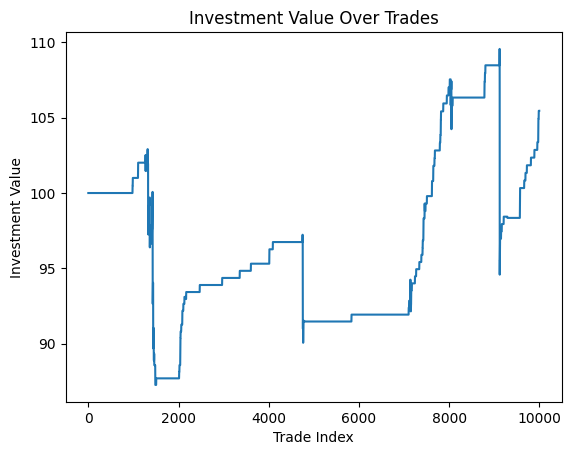

In [14]:
import matplotlib.pyplot as plt

# --- Constants ---
MINIMUM_PROBABILITY = 0.80
LEVERAGE = 1
GAIN = 0.5  # Interpreted as a percentage (e.g., 0.5% if multiplied by /100)

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
bad_trades = []
all_trades = []

initial_investment = 100
current_investment = initial_investment
investment_history = []

# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        total_trades += 1
        
        # Check if the prediction was correct
        if validation_predictions["Label"][idx] == validation_dataset["Label"][idx]:
            correct_trades += 1
            
            # Record the "gain" in your trade list
            all_trades.append(GAIN * LEVERAGE)
            
            # Update current_investment by a factor of (1 + gain%)
            current_investment *= 1 + (GAIN / 100 * LEVERAGE)
        
        else:
            # A "bad" (wrong) trade
            # Grab the next close price; watch out for index out-of-range in real code
            true_close = validation_dataset[f"{TICKER}:close4"][idx + 1]
            
            # Record the trade details
            bad_trades.append(round(true_close * LEVERAGE, 3))
            all_trades.append(true_close * LEVERAGE)

            # Update current_investment by (1 + some factor of true_close?)
            current_investment *= 1 + (true_close / 100 * LEVERAGE)
    
    else:
        all_trades.append(0)

    # In all cases, record the current investment amount
    investment_history.append(current_investment)

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0
total_return = current_investment - initial_investment

# --- Print results ---
print(f"CORRECT: {correct_trades}")
print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"WIN RATE: {round(win_rate, 2)}%")
print(f"RETURN: {round(total_return, 2)}%")
print(f"INVESTMENT VALUE: {round(current_investment, 2)}kr")
print(f"SHARP RATIO: {calculate_sharpe_ratio(all_trades)}")
sharpe_ratio9999 = calculate_sharpe_ratio(validation_dataset[f"{TICKER}:close4"].to_list())
print(f"SHARP RATIO ONLY HOLDING ASSET: {sharpe_ratio9999}")
if len(bad_trades) > 0:
    print(f"MEAN RETURN BAD TRADES: {st.mean(bad_trades)}")
print("-" * 34)

# Print information about bad trades
for trade in bad_trades:
    print(trade)

# --- Plot the investment history ---
plt.plot(investment_history)
plt.xlabel("Trade Index")
plt.ylabel("Investment Value")
plt.title("Investment Value Over Trades")
plt.show()

In [ ]:
######################## OLD FILE #################################
##################### PROBABILITY ANALYSIS AND EXPECTED RETURNS
################# Probability analysis ###########################
import statistics as st

# Minimum required confidence for executing a trade
PROB_THRESH = 0.65
LEVERAGE = 1

# display(test_tabular_dataset)
# display(test_data_frame2[LABEL][len(labelled_data_frame) - VALIDATION_SIZE])


y_prob = predictor.predict_proba(test_tabular_dataset.drop(columns=[LABEL]))
# display(y_prob)

counter = 0
correct = 0

predicted_high_list = []
predicted_low_list = []
predicted_close_list = []

balance = 100

hour_count = 0
month_gain = []
month = 100


first_index_dataset = len(labelled_data_frame) - VALIDATION_SIZE

print("------------------- TRADES: ------------------------------")
for index, pred in enumerate(y_pred):
    try:
        index = index + first_index_dataset
        prob = y_prob[1][index]
        actual = test_data_frame2["Label"][index]

        true_high = test_data_frame2[f"{TICKER}:high4"][index + 1]
        true_low = test_data_frame2[f"{TICKER}:low4"][index + 1]
        true_close = test_data_frame2[f"{TICKER}:close4"][index + 1]
        

        if prob > PROB_THRESH:
            counter += 1

            if pred == 1 and actual == 1:
                correct += 1
                predicted_high_list.append(true_high)
                predicted_low_list.append(true_low)
                predicted_close_list.append(true_close)

            ### LOGIC FOR CALCULATING GAIN ###
            if true_high >= 0.5:
                balance *= 1 + (0.005 * LEVERAGE)
                month *= 1 + (0.005 * LEVERAGE)
                print(f"{index}. Gain +5%")
            else:
                balance *= 1 + ((true_close / 100) * LEVERAGE)
                month *= 1 + ((true_close / 100) * LEVERAGE)
                #print(f"{index}. Close + {true_close} ---> High: {true_high}, Low: {true_low}, Close: {true_close}")
                print(f"{index}. Close +{true_close * LEVERAGE}")
    
        hour_count += 1
        if hour_count == 730:
            hour_count = 0
            month_gain.append(round(month - 100, 3))
            month = 100

    except Exception as e:
        print(f"Got following error: {e}")


month_gain.append(month - 100)

        

print("------------------------------------------")
print(f"Correct: {correct}")
print(f"Counter: {counter}")
print(f"Winrate: {correct / counter}")

print(f"AVG High: {st.mean(predicted_high_list)}")
print(f"AVG Low: {st.mean(predicted_low_list)}")
print(f"AVG Close: {st.mean(predicted_close_list)}")
print()
print(f"Balance: {balance}")
print(f"Return: {balance - 100}%")
print()
print(f"Month List: {month_gain}")
print(f"Mean month gain: {st.mean(month_gain)}")

CORRECT: 9
WRONG: 9
NUMBER OF TRADES: 18
WIN RATE: 50.0%
----------------------------------
MEAN GOOD TRADES: 3.296007106607836
MEAN BAD TRADES: -1.0952135374144845
-0.542397660818712
-0.45242914979758286
1.6070923240184014
-1.7298372179060382
5.521767810026385
0.4375934230194226
1.9767206477732886
-0.10456660849331834
1.556167400881058
-0.1818955732122562
-2.370141342756187
6.07235084594836
-3.9397274633123796
3.8422942969090172
5.5091623036649064
-0.6519292604501523
0.1160024400162662
3.140914907229682
RETURN: 20.977 %


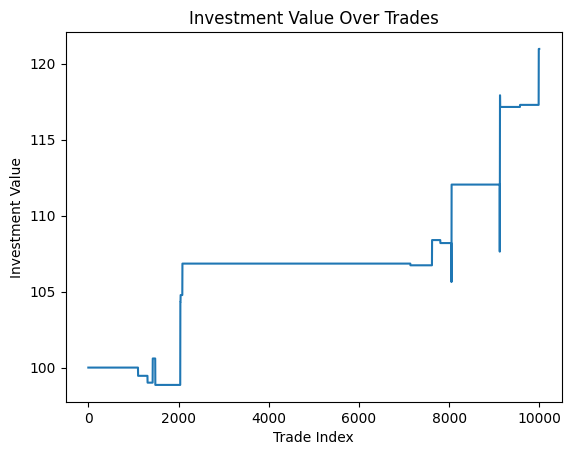

In [25]:
############### ANALYSIS OF NEGATIVE VALUE PREDICTIONS ################################

# --- Constants ---
MINIMUM_PROBABILITY = 0.87
TRADING_FEE = 0.25
LEVERAGE = 1

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
wrong_trades = 0

all_trades = []
good_trades = []
bad_trades = []
investment1 = 100
investment_history2 = []

# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        true_close = (validation_dataset[f"{TICKER}:close4"][idx + 1] - TRADING_FEE) * LEVERAGE
        
        if true_close >= 0.25:
            correct_trades += 1
            good_trades.append(true_close)
        else:
            bad_trades.append(true_close)

        total_trades += 1
        all_trades.append(true_close)
        investment1 *= 1 + (true_close / 100)
    investment_history2.append(investment1)
            

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0

# --- Print results ---
print(f"CORRECT: {correct_trades}")
print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"WIN RATE: {round(win_rate, 2)}%")
print("-" * 34)

print(f"MEAN GOOD TRADES: {st.mean(good_trades)}")
print(f"MEAN BAD TRADES: {st.mean(bad_trades)}")


for trade in all_trades:
    print(trade)

print(f"RETURN: {round(investment1 - 100, 3)} %")

# --- Plot the investment history ---
plt.plot(investment_history2)
plt.xlabel("Trade Index")
plt.ylabel("Investment Value")
plt.title("Investment Value Over Trades")
plt.show()